# Elektrische Eigenschaften von Akkus mit dem M1K messen
Version 17.1.2021, S. Mack  

Der M1K aka ADALM1000 ist eine sogenannte *Source Measurement Unit* abgekürzt *SMU*. Damit ist ein Gerät gemeint, welches sowohl Spannungen und Ströme erzeugen als auch messen kann.  
Der M1K-Platine beinhaltet ein Zweikanal-Oszilloskop mit maximal 200 kS/s Abtastrate. Alternativ können die beiden Kanäle auch als Spannungs- oder Stromquelle eines ebenfalls integrierten 100 kS/s Funktionsgenerators (AWG) agieren, um beliebige Testsignale zu erzeugen. Dann werden an beiden Kanälen neben den Spannungen auch die Ströme gemessen, welche diese Quellen erzeugen. Die Strommessung geschieht über interne Shunt-Widerstände des M1K.
Das simultane Messen von Spannungen und Strömen geschieht mit maximal 100 kS/s.  

Darüber hinaus besitzt der M1K vier digitale GPIOs, die z.B. für eine I²C-Kommunikation verwendet werden können.

Der M1K wird via USB mit dem PC verbunden. Angesteuert und ausgelesen wird er mit C++ oder Python-Programmen.
Nähere Infos siehe: wiki.analog.com/university/tools/m1k

**In den nachfolgenden Abschnitten wird der M1K dazu verwendet, um den Aufladevorgang eines Akkus messtechnisch zu charakterisieren.** Er dient dabei als Stromquelle und misst den komplexen Innenwiderstand über den Strom-/Spannungsverlauf am Akku. Als Akku wird eine NiMH-Knopfzelle mit einer Kapazität von 80 mAh verwendet.

![M1K mit Knopfzellenakku](80mAhAkkuM1k.JPG)

Wie im Bild oben dargestellt wird dem Knopfzellenakku über den Kanal B des M1K ein Ladestrom eingeprägt. Ein 100 Ohm Widerstand ist vorgeschaltet, damit die Stromquelle trotz geringen Innenwiderstand der Knopfzelle stabil bleibt.  
Kanal A des M1K befindet sich im High Impedance Modus, d.h. hiermit wird die Ladespannung an der Batterie erfasst.

Sowohl die Mess- als auch die Auswertesoftware ist in Python geschrieben. Um den M1K über Python-Skripte anzusteuern, muss auf dem PC die Laufzeitbibliothek *libsmu* sowwie das Python-Modul *pysmu* vorhanden sein. Installationshinweise hierzu finden sich unter github.com/StefanMack/M1K.

>Dieses Jupyter-Notebook kann nicht unter Binder sondern nur lokal auf einem PC ausgeführt werden, wobei die beiden o.g. Softwarekomponenten auf dem PC installiert sein müssen. **Ansonsten sind hier nur die Pythonskripte zur Darstellung der Messwerte, die als Textdateien im Verzeichnis dieses Notebooks vorliegen, ausführbar.**

## Messen der Ladekapazität und des Gleichstrom-Innenwiderstandes während des Ladevorgangs
Wenn ein Akku wie üblich mit Gleichstrom geladen wird, ist es ohne Unterbrechen des Ladevorgangs nicht möglich dessen Innenwiderstand zu messen. Man kann den Strom während des Ladens messen nicht jedoch die dadurch am Akku abfallende Spannung: Denn die Ladespannung ist die Summe dieses Spannungsabfalls und der momentanen Leerlaufspannung des Akkus.  
Letztere Spannung kann nur beim Unterbrechen des Ladevorgangs gemessen werden.  

**Wird jedoch ein sinusförmiger Wechselanteil auf den Ladestrom aufmoduliert, so kann der differentieller Widerstand aus dem Verhältnis der Spannungsamplitude zur Stromamplitude gemessen werden. Dieser Widerstand ist gleich dem Innenwiderstand des Akkus.**  

Er hängt vom Ladezustand (SOC), von der Alterung (SOH), vom Gleichanteil des Stroms sowie von der Frequenz des Wechselanteils ab.  
Da der Strom- und der Spannungsverlauf auch einen Phasenversatz aufweisen, spricht man statt vom Innenwiderstand von der *Impedanz* des Akkus. Diese hat einen Betrag und eine Phase.  

Das folgende Messskript bestimmt während des Ladevorgangs den Betrag der Akku-Impedanz in Abhängigkeit von der Ladezeit und der in den Akku geflossenen Ladung. Der Ladevorgang geschieht bei einem vorgegebenen konstanten Gleich-/(Sinus-)Wechselanteil und bei konstanter Frequenz des Stroms.   

In [ ]:
import time
import threading as th # damit im getrennten Thread Return-Eingabe erkannt wird
import numpy as np
from pysmu import Session, Mode


SAMP_RATE = 100000
NUM_SAMPLES = 10000
AWGB_IVAL_MIN = 100 # 140
AWGB_IVAL_MAX = 120 # 180
FREQ = 100
TIME_STEP = 5 # Messzuyklus in Sekunden
FILE_NAME = 'bat-charge.txt'
CURR_OFFSET = 14.7 # M1K current measurement offset

keep_going = True # Flag um While-Schleife der Messung zu beenden

# wird als 2. Thread ausgeführt um Return-Eingabe zu erkennen
def key_capture_thread(): 
    global keep_going
    input()
    keep_going = False
    
meas_file = open(FILE_NAME,'w')

meas_file.write('Messreihe Ladevorgang Akku: AC ist Effektivwert\n')
meas_file.write('Frequenz: {} Hz, Sin-Min: {} mA, Sin-Max: {} mA\n\n'.format(FREQ,AWGB_IVAL_MIN,AWGB_IVAL_MAX))
meas_file.write('t [s]; U_DC [v]; I_DC [mA]; R_DC [Ohm]; U_AC [v]; I_AC [mA]; R_Diff [Ohm]; C [mAh] \n\n')

# 2. Thread starten
th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
print('Zum Beenden Return drücken...')
print()

session = Session(ignore_dataflow=True, sample_rate=SAMP_RATE, queue_size=NUM_SAMPLES)
if session.devices:
    dev = session.devices[0]
    DevID = dev.serial
    print("Device ID:" + str(DevID))
    FWRev = float(dev.fwver)
    HWRev = str(dev.hwver)
    print('Firmware Revision: {}, Hardware Revision: {}'.format(FWRev, HWRev))
    print()
    if FWRev < 2.17:
        print("WARNING: Firmware version > 2.16 required!")

    session.flush()
    CHA = dev.channels['A']    # Open CHA
    CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
    CHB = dev.channels['B']    # Open CHB
    CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode  
    dev.set_adc_mux(0) # kein ADC-Mux, d.h. Abtasten CA-V/I und CB-V/I

    CHA.mode = Mode.HI_Z
    CHB.mode = Mode.SIMV # Put CHA in SIMV mode
    periodval = SAMP_RATE/FREQ
    min_i = AWGB_IVAL_MIN/1000
    max_i = AWGB_IVAL_MAX/1000
    CHB.sine(max_i, min_i, periodval, 0)    
    session.start(0)

    print("Zeit (s) DC/AC: Spannung (V) Strom (mA) Widerstand (Ohm) Ladung (mAh)")
    print("---------------------------------------------------------------------")
    start_time = time.time()
    charge_val = 0
    adc_signal = dev.read(10000, -1, True)  # Dummy Auslesen, sonst fehlerhafte Werte im Array
    time.sleep(0.2)
    
    while keep_going:
        adc_signal = dev.read(NUM_SAMPLES, -1, True) # Samples aller vier Kanaele auslesen 

        cha_u_vals = [] # Buffer loeschen
        cha_i_vals = []
        chb_u_vals = []
        chb_i_vals = []
  
        index = 0
        num_samples_real = NUM_SAMPLES

        if num_samples_real != len(adc_signal): # manchmal gibt ADC weniger Samples zurueck als angefordert
            num_samples_real = len(adc_signal)
            
        while index < num_samples_real:
            cha_u_vals.append(adc_signal[index][0][0])
            cha_i_vals.append(adc_signal[index][0][1])
            chb_u_vals.append(adc_signal[index][1][0])
            chb_i_vals.append(adc_signal[index][1][1])
            index = index + 1
        
        cha_u_vals = np.asarray(cha_u_vals)
        chb_i_vals = np.asarray(chb_i_vals) - CURR_OFFSET/1000 # Offset Korrektur
        
        u_ave = cha_u_vals.mean()
        i_ave = chb_i_vals.mean()
        r_ave = u_ave / i_ave
        u_std = cha_u_vals.std()
        i_std = chb_i_vals.std()
        r_std = u_std / i_std
        charge_val = charge_val + TIME_STEP * i_ave
        meas_time = int(time.time() - start_time)
        print("t={:4}: DC: U={:6.3f} V, I={:7.4f} mA, R={:6.3f} Ohm   AC: U={:8.6f} V, I={:7.4f} mA, R={:6.4f} Ohm  C={:4.1f} mAh"\
        .format(meas_time, u_ave, i_ave*1000, r_ave, u_std, i_std*1000, r_std, charge_val))
        meas_file.write("{};{:.3f};{:.4f};{:.3f};{:.6f};{:.4f};{:.4f};{:4.1f}\n"\
        .format(meas_time, u_ave, i_ave*1000, r_ave,u_std, i_std*1000, r_std, charge_val))
        time.sleep(TIME_STEP)

    print('Programm wurde durch Return-Eingabe beendet.')
    meas_file.close()
    time.sleep(2)
    # damit M1K nach Beenden im sicheren Zustand
    CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
    CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode
    CHA.constant(0.0)
    CHB.constant(0.0)
    if session.continuous:
        session.end()
    session.remove(dev) # damit kein Problem beim erneutem Programmstart.     
else:
    print('no devices attached')

Das Mess-Skript oben schreibt die Messergebnisse in die Datei `bat-charge.txt`.  
Darin befindet sich ab Zeile 6 mit `;` getrennt die 
1. Zeit in Sekunden, 
2. der Gleichanteil (DC) der Akkuspannung in Volt,
3. der Gleichanteil (DC) des Ladestroms in mA,
4. der daraus berechnete (scheinbare) Gleichstromwiderstand in Ohm,
5. der Wechselanteil (AC) der Akkuspannung in Volt,
6. der Wechselanteil (AC) des Stroms in mA,
7. der daraus berechnete diferentielle Widerstand in Ohm sowie
7. die aus dem Stromverlauf gemessene Ladung in mA.  

Das nachfolgende Skript list die o.g. Datei aus und stellt den zeitlichen Verlauf der DC-Spannung sowie des differentiellen Widerstands, also des Innenwiderstands dar.

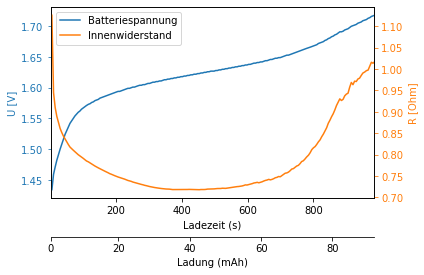

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Werte aus Textdatei in Array einlesen: Erste 5 Zeilen ignorieren, ';' als Trennzeichen
# verwenden und nur die Spalten 0,1,6 und 7 einlesen.
data = np.loadtxt('bat-charge.txt',skiprows=6, usecols=(0,1,6,7), delimiter=';')
t = data[:,0]
bat_charge = data[:,3]
bat_volt = data[:,1]
bat_resistance = data[:,2]
DELTA = 1 # Bug Workaround, sonst 1. und letzter Tic sek. X-Achse falsches Lable

def forward(x): # Transformation Ladezeiten (Spalte 0) auf Ladung (Spalte3)
    return np.interp(x, t, bat_charge)
def inverse(x): # Transformation  Ladung (Spalte3) auf Ladezeiten (Spalte 0)
    return np.interp(x, bat_charge, t)

fig, ax1 = plt.subplots()

ax1.plot(t, bat_volt, '-',color='C0', label='Batteriespannung', zorder=10)
ax1.set_xlabel('Ladezeit (s)')
ax1.set_ylabel('U [V]', color='C0')
ax1.tick_params('y', colors='C0')
ax1.set_xlim(DELTA,max(t)-DELTA) # Bug Workaround wegen Tics s.o.
# Zweite X-Achse unterhalb der ersten über Transformationen s.o.
secax1 = ax1.secondary_xaxis(location = -0.2,functions=(forward, inverse))
secax1.set_xlabel('Ladung (mAh)')

ax2 = ax1.twinx() # Zweite Y-Achse mit gemeinsamer X-Achse
ax2.plot(t, bat_resistance, '-',color='C1',label='Innenwiderstand', zorder=1)
ax2.set_ylabel('R [Ohm]', color='C1')
ax2.tick_params('y', colors='C1')
ax2.set_xlim(DELTA,max(t)-DELTA) # Bug Workaround wegen Tics s.o.

fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

Der Innenwiderstand des Akkus fällt zuerst ab und steigt, wenn der Akku voll geladen wird steil an. Zu diesem Zeitpunkt steigt auch die Ladespannung an, da der M1K immer noch den gleichen eingestellen Strom in den Akku einprägt.  

Wieso der Verlauf des Innenwiderstands ab dem Ladeende bei ca. 80 mAh merklich höher schankt ist unklar.  

Der hier gemessene Innenwiderstand von ca. 1 Ohm ist vergleichsweise hoch für einen NiMH-Akku. Er ist aber typisch für eine Knopfzellenform dieses Akkutyps.  

## Messung der komplexen Impedanz des Akkus
   
Der Stromverlauf ist wie im vorang gegangenen Abschnitt ein Sinus-modulierter Gleichstrom. Daraus ergibt sich eine ebenfalls sinusförmiger Spannung am Akku, welche einen kleinen kapazitiven Phasenversatz (die Spannung eilt dem Strom nach) zum Strom aufweist.  
Wie im Messskript zuvor wird aus dem Verhältnis der Strom- und Spannungsamplitude der Betrag der Akkuimpedanz (= differentieller Widerstand bzw. Innenwiderstand) bestimmt.  

**Nun wird zusätzlich noch der Phasenversatz des Wechselanteils von Strom und Spannung gemessen und ausgegeben.**   
Dazu werden während einigen Perioden sowohl der Strom- als auch der Spannungsverlauf am Akku erfasst. Dies geschieht bei einem vorgegebenen festen Ladestrom und bei einer konstanten Frequenz dessen Wechselanteils.  

Der Phasenversatz zwischen Strom und Spannung kann auf unterschiedliche Weisen bestimmt werden. Nachfolgend werden zwei unterschiedliche Auswertetechniken dazu vorgestellt: Die Kreuzkorrelation und ein Kurvenfit.

### Bestimmung des Phasensersatzes über eine Kreuzkorrelation
Beim Strom- wie beim Spannungsverlauf handelt es sich um Sinusverläufe mit der gleichen Frequenz. Normiert man beide Signalverläufe auf einen Offset gleich Null und eine Amplitude von Eins, so unterscheiden sie sich nur noch in deren Phase.  

**Für einen Wellenzug von wenigen Perioden besitzt die Kreuzkorrelation zwischen dem normierten Stromsignal und Spannungsignal ein eindeutiges Maximum zu dem Zeitpunkt, an dem beide Signale komplett überlappen.**  
D.h. dieser Zeitpunkt des Maximums gibt die zeitliche Verschiebung der beiden Signale wieder. Daraus wird mit der bekannten Signalfrequenz der Phasenversatz berechnet.  

In dem folgenden Messskript werden zuerst die Signalverläufe von Strom und Spannung über vier Perioden erfasst. Dann wird dazu die Kreuzkorrelation berechnet und deren Maximalwert ermittelt. Der damit ermittelte zeitliche Versatz der beiden Signale wird in einen Phasenversatz umgerechnet.

Device ID:20312044374D4334203230323430313
Firmware Revision: 2.17, Hardware Revision: D

Anlegen des Sinusstroms für 5 Sekunden zur Saettigung der Batteriespannung...
noch 1 Sekunden
Start Messung: Frequenz=7 Hz, i_min=20 mA, i_max=60 mA
DC: U= 1.399 V, I=39.5496 mA  AC: U=0.016350 V, I=13.8095 mA, R=  1.1840 Ohm
U zu I: Zeitversatz (ms): 4.110, Phasenversatz (rad/deg): 0.181/10.357


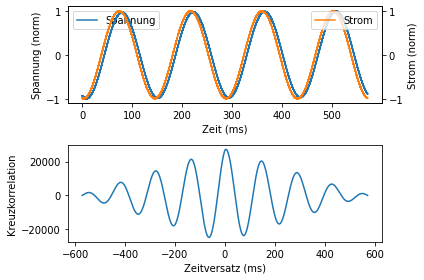

In [1]:
import time
import numpy as np
from pysmu import Session, Mode
import matplotlib.pyplot as plt
from scipy.signal import correlate


SAMP_RATE = 100000
AWGB_IVAL_MIN = 20 # Minimum Sinus in mA
AWGB_IVAL_MAX = 60 # Maximum Sinus in mA
FREQ = 7 # Frequenz in Hz
WAIT_SATURATION = 5 # 20 s Wartezeit für Sättigung Batteriespannung
NUM_PERIOD = 4 # Anzahl der zu vermessenden Perioden
CURR_OFFSET = 0 # M1K current measurement offset mA

NUM_SAMPLES = np.round(SAMP_RATE*NUM_PERIOD/FREQ,0)

try:
    session = Session(ignore_dataflow=True, sample_rate=SAMP_RATE, queue_size=NUM_SAMPLES)
    if session.devices:
        dev = session.devices[0]
        DevID = dev.serial
        print("Device ID:" + str(DevID))
        FWRev = float(dev.fwver)
        HWRev = str(dev.hwver)
        print('Firmware Revision: {}, Hardware Revision: {}'.format(FWRev, HWRev))
        print()
        if FWRev < 2.17:
            print("WARNUNG: Firmware version > 2.16 noetig!")
    
        session.flush()
        CHA = dev.channels['A']    # Open CHA
        CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
        CHB = dev.channels['B']    # Open CHB
        CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode  
        dev.set_adc_mux(0) # kein ADC-Mux, d.h. Abtasten CA-V/I und CB-V/I
    
        CHA.mode = Mode.HI_Z
        CHB.mode = Mode.SIMV # Put CHA in SIMV mode
        periodval = SAMP_RATE/FREQ
        min_i = AWGB_IVAL_MIN/1000
        max_i = AWGB_IVAL_MAX/1000
        CHB.sine(max_i, min_i, periodval, 0)    
        session.start(0)
        print('Anlegen des Sinusstroms für {} Sekunden zur Saettigung der Batteriespannung...'.format(WAIT_SATURATION))
        for time_step in range(0,WAIT_SATURATION,1):
            print('\rnoch {} Sekunden'.format(WAIT_SATURATION-time_step), end='\r')
            time.sleep(1)
        print('')
        print('Start Messung: Frequenz={} Hz, i_min={} mA, i_max={} mA'.format(FREQ,AWGB_IVAL_MIN,AWGB_IVAL_MAX))
    
        adc_signal = dev.read(10000, -1, True)  # Dummy Abtasten um fehlerhafte Werte im Array zu verindern
        time.sleep(0.2)
        adc_signal = dev.read(NUM_SAMPLES, -1, True) # Samples aller vier Kanäle auslesen
    
        cha_u_vals = [] # Buffer loeschen
        cha_i_vals = []
        chb_u_vals = []
        chb_i_vals = []
      
        index = 0
        num_samples_real = NUM_SAMPLES
    
        if num_samples_real != len(adc_signal): # manchmal gibt ADC weniger Samples zurück als angefordert
            num_samples_real = len(adc_signal)
            
        while index < num_samples_real:
            cha_u_vals.append(adc_signal[index][0][0])
            cha_i_vals.append(adc_signal[index][0][1])
            chb_u_vals.append(adc_signal[index][1][0])
            chb_i_vals.append(adc_signal[index][1][1])
            index = index + 1
        
        cha_u_vals = np.asarray(cha_u_vals)
        chb_i_vals = 1000*np.asarray(chb_i_vals)
        
        u_ave = cha_u_vals.mean()
        i_ave = chb_i_vals.mean() - CURR_OFFSET # Offset correction
        r_ave = u_ave / i_ave * 1000
        u_std = cha_u_vals.std()
        i_std = chb_i_vals.std()
        r_std = u_std / i_std * 1000
    
        print("DC: U={:6.3f} V, I={:7.4f} mA  AC: U={:8.6f} V, I={:7.4f} mA, R={:8.4f} Ohm"\
        .format(u_ave, i_ave, u_std, i_std, r_std))
    
        voltage_norm = (cha_u_vals-u_ave)*2/(cha_u_vals.max()-cha_u_vals.min())
        current_norm = (chb_i_vals-i_ave)*2/(chb_i_vals.max()-chb_i_vals.min())
        t = np.arange(0, NUM_SAMPLES/SAMP_RATE, 1/SAMP_RATE)*1000 # Abtastzeiten
        
        xcorr = correlate(voltage_norm, current_norm) # Kreuzkorrelation
        dt = np.linspace(-t[-1], t[-1], 2*NUM_SAMPLES-1) # Zeiten Kreuzkorrelation
        time_shift = dt[xcorr.argmax()]
        phase_shift_rad = 2*np.pi*time_shift/1000*FREQ
        phase_shift_deg = 360*time_shift/1000*FREQ
        
        print('U zu I: Zeitversatz (ms): {:4.3f}, Phasenversatz (rad/deg): {:4.3f}/{:4.3f}'.format(time_shift,phase_shift_rad,phase_shift_deg))
        
        fig, ax = plt.subplots(2,1)
    
        ax[0].plot(t, voltage_norm,color='C0', label='Spannung', zorder=10)
        ax[0].set_xlabel('Zeit (ms)')
        ax[0].set_ylabel('Spannung (norm)')
    
        ax_twin = ax[0].twinx()
        ax_twin.plot(t, current_norm,color='C1',label='Strom', zorder=1)
        ax_twin.set_ylabel('Strom (norm)')
    
        ax[0].legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax[0].transAxes)
        ax_twin.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax_twin.transAxes)
        
        ax[1].plot(dt,xcorr,color='C0', label='Cross Correlation')
        ax[1].set_xlabel('Zeitversatz (ms)')
        ax[1].set_ylabel('Kreuzkorrelation')
        
        fig.tight_layout()
        plt.show()
    
    else:
        print('kein M1K angeschlossen')
except:
    print('...da ging wohl was schief...')

finally:
    # damit M1K nach Beenden im sicheren Zustand
    CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
    CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode
    CHA.constant(0.0)
    CHB.constant(0.0)
    if session.continuous:
        session.end()
    time.sleep(0.2)
    session.remove(dev) # damit kein Problem beim erneuten Start    

Aufgrund der maximalen Samplingrate von 100 kS/s kann über die Kreuzkorrelation der zeitlichen Vesatz nur mit einer Auflösung von 10 µs ermittelt werden. *Die damit sich ergebende Auflösung der Phasenmessung ist zu gering.*  
Im nachfolgendem Abschnitt wird der Phasenversatz über einen Kurvenfit berechnet. Hier wirkt sich die Abtastrate des M1K weit weniger auf die Messgenauigkeit der Phase aus.

### Bestimmung des Phasenversatzes über einen Kurvenfit
Hier wird der Phasenversatz zwischen Strom und Spannung berechnet, indem für beide Signale getrennt numerisch eine Sinusfunktion  über die Funktion `curve_fit()` angepasst wird. Der Phasenversatz wird aus der Differenz der Phasen der beiden Kurvenfits berechnet.   
Im Plot werden die beiden Messwertkurven sowie die dazu angepassten Kurven dargestellt.

Device ID:20312044374D4334203230323430313
Firmware Revision: 2.17, Hardware Revision: D

Anlegen des Sinusstroms für 10 Sekunden zur Saettigung der Batteriespannung...
noch 1 Sekundenn
Start Messung: Frequenz=140 Hz, i_min=20 mA, i_max=60 mA
DC: U= 1.263 V, I=39.5221 mA   AC: U=0.015247 V, I=13.8002 mA, R=  1.1048 Ohm
Phase U (rad): 3.020  Phase I (rad): 3.165
I zu U: Phasenversatz (rad/deg): 0.145/8.312


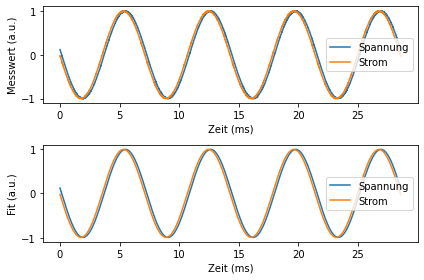

In [3]:
import time
import numpy as np
from pysmu import Session, Mode
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


SAMP_RATE = 100000
AWGB_IVAL_MIN = 20 # mA! 20 Minimum Sinus in mA
AWGB_IVAL_MAX = 60 # mA ! 60 Maximum Sinus in mA
FREQ = 140 # Frequenz in Hz
WAIT_SATURATION = 10 # s 10 Wartezeit für Sättigung Batteriespannung
NUM_PERIOD = 4 # 4 Anzahl der zu vermessenden Perioden
CURR_OFFSET = 0 # mA! M1K Offsetfehler Strommessung

NUM_SAMPLES = np.round(SAMP_RATE*NUM_PERIOD/FREQ,0)

def my_sin(x, omega, amplitude, phase, offset): # Sinusfunktion fuer Fit
    return np.sin(x * omega + phase) * amplitude + offset

try:
    session = Session(ignore_dataflow=True, sample_rate=SAMP_RATE, queue_size=NUM_SAMPLES)
    if session.devices:
        dev = session.devices[0]
        DevID = dev.serial
        print("Device ID:" + str(DevID))
        FWRev = float(dev.fwver)
        HWRev = str(dev.hwver)
        print('Firmware Revision: {}, Hardware Revision: {}'.format(FWRev, HWRev))
        print()
        if FWRev < 2.17:
            print("WARNUNG: Firmware version > 2.16 noetig!")
    
        session.flush()
        CHA = dev.channels['A']    # Open CHA
        CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
        CHB = dev.channels['B']    # Open CHB
        CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode  
        dev.set_adc_mux(0) # kein ADC-Mux, d.h. Abtasten CA-V/I und CB-V/I
    
        CHA.mode = Mode.HI_Z
        CHB.mode = Mode.SIMV # Put CHA in SIMV mode
        periodval = SAMP_RATE/FREQ
        min_i = AWGB_IVAL_MIN/1000
        max_i = AWGB_IVAL_MAX/1000
        CHB.sine(max_i, min_i, periodval, 0)    
        session.start(0)
        print('Anlegen des Sinusstroms für {} Sekunden zur Saettigung der Batteriespannung...'.format(WAIT_SATURATION))
        for time_step in range(0,WAIT_SATURATION,1):
            print('\rnoch {} Sekunden'.format(WAIT_SATURATION-time_step), end='\r')
            time.sleep(1)
        print('')
        print('Start Messung: Frequenz={} Hz, i_min={} mA, i_max={} mA'.format(FREQ,AWGB_IVAL_MIN,AWGB_IVAL_MAX))
    
        adc_signal = dev.read(10000, -1, True)  # Dummy Abtasten sonst fehlerhafte Werte im Array
        time.sleep(0.2)
        adc_signal = dev.read(NUM_SAMPLES, -1, True) # Samples aller vier Kanaele auslesen
    
        cha_u_vals = [] # Buffer loeschen
        cha_i_vals = []
        chb_u_vals = []
        chb_i_vals = []
      
        index = 0
        num_samples_real = NUM_SAMPLES
    
        if num_samples_real != len(adc_signal): # manchmal gibt ADC weniger Samples zurück als angefordert
            num_samples_real = len(adc_signal)
            
        while index < num_samples_real:
            cha_u_vals.append(adc_signal[index][0][0])
            cha_i_vals.append(adc_signal[index][0][1])
            chb_u_vals.append(adc_signal[index][1][0])
            chb_i_vals.append(adc_signal[index][1][1])
            index = index + 1
        
        cha_u_vals = np.asarray(cha_u_vals)
        chb_i_vals = np.asarray(chb_i_vals) - CURR_OFFSET/1000 # Offset Korrektur
        
        u_ave = cha_u_vals.mean()
        i_ave = chb_i_vals.mean()
        u_std = cha_u_vals.std()
        i_std = chb_i_vals.std()
        r_std = u_std / i_std
    
        print("DC: U={:6.3f} V, I={:7.4f} mA   AC: U={:8.6f} V, I={:7.4f} mA, R={:8.4f} Ohm"\
        .format(u_ave, i_ave*1000, u_std, i_std*1000, r_std))
    
        voltage_norm = (cha_u_vals-u_ave)*2/(cha_u_vals.max()-cha_u_vals.min())
        current_norm = (chb_i_vals-i_ave)*2/(chb_i_vals.max()-chb_i_vals.min())
        t = np.arange(0, NUM_SAMPLES/SAMP_RATE, 1/SAMP_RATE)*1000 # Abtastzeiten in ms
        
        fit_start_vals=[FREQ*2*np.pi, 1.0, 0.0, 0.0] # Startwerte Fit (Freq, Ampl, Phase, Offset)
        voltage_fit_result = curve_fit(my_sin, t/1000, voltage_norm, p0=fit_start_vals) # bounds funktionieren nicht richtig
        current_fit_result = curve_fit(my_sin, t/1000, current_norm, p0=fit_start_vals)
        
        if(voltage_fit_result[0][1]>=0):
            phase_voltage = voltage_fit_result[0][2]
        else: # falls negative Amplitude als Fit Umrechnung Phase auf positive Ampliude
            phase_voltage = voltage_fit_result[0][2] + np.pi
        if(current_fit_result[0][1]>=0):
            phase_current = current_fit_result[0][2]
        else: # s.o.
            phase_current = current_fit_result[0][2] + np.pi
        
        phase_shift_rad = (phase_current - phase_voltage)
        if(phase_shift_rad<0): phase_shift_rad = phase_shift_rad + 2*np.pi # Phasenversatz u zu I immer positiv
        phase_shift_deg = 180*phase_shift_rad/np.pi
        
        print('Phase U (rad): {:4.3f}  Phase I (rad): {:4.3f}'.format(phase_voltage,phase_current))
        print('I zu U: Phasenversatz (rad/deg): {:4.3f}/{:4.3f}'.format(phase_shift_rad,phase_shift_deg))
        
        voltage_fit = my_sin(t/1000, *voltage_fit_result[0])
        current_fit = my_sin(t/1000, *current_fit_result[0])
        
        fig, ax = plt.subplots(2,1)
    
        ax[0].plot(t, voltage_norm, color='C0', label='Spannung')
        ax[0].plot(t, current_norm, color='C1', label='Strom')
        ax[0].set_xlabel('Zeit (ms)')
        ax[0].set_ylabel('Messwert (a.u.)')  
        ax[0].legend()
    
        ax[1].plot(t,voltage_fit,color='C0', label='Spannung')
        ax[1].plot(t,current_fit,color='C1', label='Strom')
        ax[1].set_xlabel('Zeit (ms)')
        ax[1].set_ylabel('Fit (a.u.)')
        ax[1].legend()
        
        fig.tight_layout()
        plt.show()
    
    else:
        print('kein M1K angeschlossen')
except:
    print('...da ging wohl was schief...')

finally:
    # damit M1K nach Beenden im sicheren Zustand
    CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
    CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode
    CHA.constant(0.0)
    CHB.constant(0.0)
    if session.continuous:
        session.end()
    time.sleep(0.2)
    session.remove(dev) # damit kein Problem  beim erneuten Start.

## Impedanzspektroskopie: Komplexe Impedanz des Akkus in Abhängigkeit von der Frequenz
Die komplexe Impedanz eines Akkus hängt von vielen Faktoren ab wie beispielsweise der Ladezustand (SOC), der Temperatur oder der Akkualterung (SOH).  

Wie jede Impedanz ändert sich die Akku-Impedanz mit der *Frequenz* des Wechselanteils des eingeprägten Ladestroms. **Die Untersuchung dieser Abhängigkeit nennt man Impedanzsprektroskopie**.  

Folgendes Messskript nimmt die frequenzabhängige Impedanz für einen vorgegebenen Frequenzbereich auf. Dabei wird ähnlich wie im Skript zuvor der Phasenversatz zwischen Strom und Spannung über einen Sinus-Kurvenfit berechnet.  

In die Messdatendatei `bat-freq-sweep-phase.txt` werden für jeden Frequenzschritt in einer neuen Zeile
1. die Frequenz in Hz,
2. der DC- bzw. AC-Anteil von Spannung in V und Strom in mA,
3. sowie der Betrag der Impedanz in Ohm (differentielle Widerstand)
4. und der Phasenversatz zwischen dem Wechselanteil von Strom- und Spannung in Grad bzw. Rad  

geschrieben. 

In [4]:
import time
import threading as th # damit im getrennten Thread Return-Eingabe erkannt wird
import numpy as np
from pysmu import Session, Mode
from scipy.optimize import curve_fit


SAMP_RATE = 100000
WAIT_FIRST_CHARGE = 10 # 10 Initiale Ladezeit vor der ersten Messung
AWGB_IVAL_MIN = 20 # mA! 20 sollte gering sein damit während Sweep ähnlicher Ladezustand
AWGB_IVAL_MAX = 60 # mA! 60 sollte ca. 20-40 mA groeßer sein als AWGB_IVAL_MIN
START_FREQ = 5
STOP_FREQ = 200
FREQ_STEP = 5
NUM_PERIOD = 4 # 4 Anzahl der zu vermessenden Perioden pro Frequenz
TIME_STEP = 2 # 2 Wartezeit in Sekunden damit neue Frequenz eingeschwungen
FILE_NAME = 'bat-freq-sweep-phase.txt' # Datei zum Abspeichern Messwerte
CURR_OFFSET = 0 # mA! Offsetfehler M1K Strommessung
NUM_SAMPLES_MAX = 100000 # maximale Zahl von Abtastungen

keep_going = True # Flag um While-Schleife der Messung zu beenden
first_step = True # Flag für laengere Start-Ladezeit vor dem ersten Frquenzwert 

# wird als 2. Thread ausgeführt um Return-Eingabe zu erkennen
def key_capture_thread(): 
    global keep_going
    input()
    keep_going = False
    
def my_sin(x, omega, amplitude, phase, offset): # Sinusfunktion fuer Fit
    return np.sin(x * omega + phase) * amplitude + offset

    
meas_file = open(FILE_NAME,'w') 

meas_file.write('Messreihe Frequenzsweep Ladestrom Akku: AC ist Effektivwert\n')
meas_file.write('Frequenz Start/Stopp/Delta: {}/{}/{} Hz, Sin-Min: {} mA, Sin-Max: {} mA\n\n'
                .format(START_FREQ,STOP_FREQ,FREQ_STEP,AWGB_IVAL_MIN,AWGB_IVAL_MAX))
meas_file.write('f [Hz]; U_DC [v]; I_DC [mA]; U_AC [v]; I_AC [mA]; R_Diff [Ohm]; Phi [deg]; Phi [rad] \n\n')

# 2. Thread starten
th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
print('Zum Beenden Return drücken...')
print()



session = Session(ignore_dataflow=True, sample_rate=SAMP_RATE, queue_size=NUM_SAMPLES_MAX)
if session.devices:
    dev = session.devices[0]
    DevID = dev.serial
    print("Device ID:" + str(DevID))
    FWRev = float(dev.fwver)
    HWRev = str(dev.hwver)
    print('Firmware Revision: {}, Hardware Revision: {}'.format(FWRev, HWRev))
    print()
    if FWRev < 2.17:
        print("WARNUNG: Firmware Version > 2.16 notwendig!")

    session.flush()
    CHA = dev.channels['A']    # Open CHA
    CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
    CHB = dev.channels['B']    # Open CHB
    CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode  
    dev.set_adc_mux(0) # kein ADC-Mux, d.h. Abtasten CA-V/I und CB-V/I

    CHA.mode = Mode.HI_Z
    CHB.mode = Mode.SIMV # Put CHA in SIMV mode
    freq = START_FREQ
    min_i = AWGB_IVAL_MIN/1000 # da Konstante in mA
    max_i = AWGB_IVAL_MAX/1000 # da Konstante in mA
    
    for freq in range(START_FREQ,STOP_FREQ,FREQ_STEP):
        num_samples = np.round(SAMP_RATE*NUM_PERIOD/freq,0)
        if(keep_going):
            periodval = np.round(SAMP_RATE/freq,0)
            CHB.sine(max_i, min_i, periodval, 0)    
            session.start(0)
            if first_step: # laengeres Aufladen vor Start Messung
                print("Initiales Laden vor der ersten Messung...")
                for time_step in range(0,WAIT_FIRST_CHARGE,1):
                    print('\rnoch {} Sekunden'.format(WAIT_FIRST_CHARGE-time_step), end='\r')
                    time.sleep(1)
                print('')
                print('Start Messung: Frequenz Start/Stopp/Delta: {}/{}/{} Hz, i_min={} mA, i_max={} mA'
                      .format(START_FREQ,STOP_FREQ,FREQ_STEP,AWGB_IVAL_MIN,AWGB_IVAL_MAX))
                print('')
                print("Frequenz (HZ) -- DC/AC Spannung (V) Strom (mA) -- AC Widerstand (Ohm) -- Phase (Grad/Rad)")
                print("--------------------------------------------------------------------------------------")
                first_step = False
            time.sleep(TIME_STEP)
            adc_signal = dev.read(10000, -1, True)  # Dummy Auslesen, sonst fehlerhafte Werte im Array
            time.sleep(0.2)
            adc_signal = dev.read(num_samples, -1, True) # Samples aller vier Kanäle auslesen (blocking) 
    
            cha_u_vals = [] # Buffer loeschen
            cha_i_vals = []
            chb_u_vals = []
            chb_i_vals = []
      
            index = 0
    
            if num_samples != len(adc_signal): # manchmal gibt ADC weniger Samples zurück als angefordert
                num_samples = len(adc_signal)
                
            while index < num_samples:
                cha_u_vals.append(adc_signal[index][0][0])
                cha_i_vals.append(adc_signal[index][0][1])
                chb_u_vals.append(adc_signal[index][1][0])
                chb_i_vals.append(adc_signal[index][1][1])
                index = index + 1
            
            cha_u_vals = np.asarray(cha_u_vals)
            chb_i_vals = 1000*np.asarray(chb_i_vals) - CURR_OFFSET # Offset Korrektur
            
            u_ave = cha_u_vals.mean()
            i_ave = chb_i_vals.mean()
            r_ave = u_ave / i_ave * 1000
            u_std = cha_u_vals.std()
            i_std = chb_i_vals.std()
            r_std = u_std / i_std * 1000
            
            voltage_norm = (cha_u_vals-u_ave)*2/(cha_u_vals.max()-cha_u_vals.min())
            current_norm = (chb_i_vals-i_ave)*2/(chb_i_vals.max()-chb_i_vals.min())
            t = np.arange(0, num_samples/SAMP_RATE, 1/SAMP_RATE)*1000 # Abtastzeiten in ms (!)
            
            fit_start_vals=[freq*2*np.pi, 1.0, 0.0, 0.0] # Startwerte Fit (Freq, Ampl, Phase, Offset)
            voltage_fit_result = curve_fit(my_sin, t/1000, voltage_norm, p0=fit_start_vals) # /1000 da ms
            current_fit_result = curve_fit(my_sin, t/1000, current_norm, p0=fit_start_vals)
            
            if(voltage_fit_result[0][1]>=0):
                phase_voltage = voltage_fit_result[0][2]
            else: # falls negative Amplitude als Fit Umrechnung Phase auf positive Ampliude
                phase_voltage = voltage_fit_result[0][2] + np.pi
            if(current_fit_result[0][1]>=0):
                phase_current = current_fit_result[0][2]
            else: # s.o.
                phase_current = current_fit_result[0][2] + np.pi
            
            phase_shift_rad = (phase_current - phase_voltage)
            if(phase_shift_rad<0): phase_shift_rad = phase_shift_rad + 2*np.pi # Phasenversatz ist immer positiv
            phase_shift_deg = 180*phase_shift_rad/np.pi
            
            print("f={:4} Hz  DC: U={:5.3f} V, I={:7.4f} mA  AC: U={:8.6f} V, I={:7.4f} mA, R={:6.4f} Ohm  Phi={:5.3f} deg / {:4.4f} rad"\
            .format(freq, u_ave, i_ave, u_std, i_std, r_std, phase_shift_deg, phase_shift_rad))
            meas_file.write("{};{:.3f};{:.4f};{:.4f};{:.4f};{:.3f};{:.4f};{:.5f}\n"\
            .format(freq, u_ave, i_ave, u_std, i_std, r_std, phase_shift_deg, phase_shift_rad))
            session.end()
            time.sleep(0.5)
        else:
            print('Programm wurde durch Return-Eingabe beendet.')
            break
    meas_file.close()
    time.sleep(2)
    # Damit M1K nach Beenden im sicheren Zustand
    CHA.mode = Mode.HI_Z_SPLIT # Put CHA in Hi Z split mode
    CHB.mode = Mode.HI_Z_SPLIT # Put CHB in Hi Z split mode
    CHA.constant(0.0)
    CHB.constant(0.0)
    if session.continuous:
        session.end()
else:
    print('kein M1K angeschlossen')
    
session.remove(dev) # damit kein Problem beim erneutem Programmstart. 

Zum Beenden Return drücken...

Device ID:20312044374D4334203230323430313
Firmware Revision: 2.17, Hardware Revision: D

Initiales Laden vor der ersten Messung...
noch 1 Sekundenn
Start Messung: Frequenz Start/Stopp/Delta: 5/200/5 Hz, i_min=20 mA, i_max=60 mA

Frequenz (HZ) -- DC/AC Spannung (V) Strom (mA) -- AC Widerstand (Ohm) -- Phase (Grad/Rad)
--------------------------------------------------------------------------------------
f=   5 Hz  DC: U=1.331 V, I=39.5130 mA  AC: U=0.021093 V, I=13.8072 mA, R=1.5277 Ohm  Phi=13.957 deg / 0.2436 rad
f=  10 Hz  DC: U=1.334 V, I=39.5118 mA  AC: U=0.018605 V, I=13.8066 mA, R=1.3476 Ohm  Phi=13.910 deg / 0.2428 rad
f=  15 Hz  DC: U=1.335 V, I=39.5107 mA  AC: U=0.017309 V, I=13.8071 mA, R=1.2536 Ohm  Phi=13.379 deg / 0.2335 rad
f=  20 Hz  DC: U=1.337 V, I=39.5100 mA  AC: U=0.016456 V, I=13.8071 mA, R=1.1919 Ohm  Phi=12.840 deg / 0.2241 rad
f=  25 Hz  DC: U=1.339 V, I=39.5118 mA  AC: U=0.015873 V, I=13.8078 mA, R=1.1496 Ohm  Phi=12.323 deg / 0.21

Folgendes Skript dient zur Darstellung der Frequenzabhängigkeit der komplexen Impedanz des Akkus.  
Dazu werden die entsprechenden Spalten der zuvor erzeugten Datei `bat-freq-sweep-phase.txt` ausgelesen und der Verlauf des Betrags und der Phase der Impendanz im Abhängigkeit von der Ladestromfrequenz dargestellt.

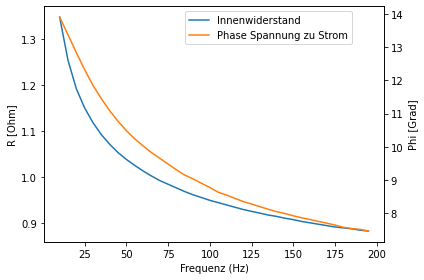

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Werte aus Textdatei in Array einlesen: Erste 6 Zeilen ignorieren, ';' als
# Trennzeichen verwenden und nur Spalten 0, 5 und 6 einlesen.
data = np.loadtxt('bat-freq-sweep-phase.txt',skiprows=6, usecols=(0,5,6), delimiter=';')
freq = data[:,0]
bat_resistance = data[:,1]
bat_phase = data[:,2]

fig, ax1 = plt.subplots()

ax1.plot(freq, bat_resistance, '-',color='C0', label='Innenwiderstand', zorder=10)
ax1.set_xlabel('Frequenz (Hz)')
ax1.set_ylabel('R [Ohm]')


ax2 = ax1.twinx() # Zweite Y-Achse mit gemeinsamer X-Achse
ax2.plot(freq, bat_phase, '-',color='C1',label='Phase Spannung zu Strom', zorder=1)
ax2.set_ylabel('Phi [Grad]')


#Legende innerhalb Plotbereich setzen
fig.legend(loc='upper left', bbox_to_anchor=(0.4,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

**Beim Plot oben stellt sich die Frage, ob das Absinken des Betrags der Impedanz eher der dem zunehmendem SOC oder der ansteigenden Frequenz geschuldet ist.**   
Dies zeigt ein prinzipielles Problem der hier vorgestellten Methode der Impedanzspektroskopie: Der Ladestrom muss zwingend einen Gleichanteil besitzen, da der M1K nicht wirklich als Stromsenke fungieren kann.  
Wenn der entsprechnde Kanal des M1K eine Spannung erzeugt, die kleiner als die momentane Leerlaufspannung des Akkus ist, kann der M1K quasi als elektronische Last einen Strom des Akkus in Entladerichtung aufnehmen. Es ist aber unklar, wie der Verlauf dieses Stroms über den M1K gesteuert werden kann.